In [ ]:
from itertools import product
import math
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as st
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern


def estimate_density(x, k=5):
    """Estimate the density of a dataset using the k-nearest neighbors method.
    
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        The dataset for which to estimate the density.
    k : int, optional (default=5)
        The number of nearest neighbors to use for density estimation.
    
    Returns
    -------
    densities : array, shape (n_samples,)
        The estimated densities for each sample in the dataset.
    """
    dens = np.zeros(len(x))

    # The volume of a unit d-dimensional ball is given by the formula
    # V = pi^(d/2) / gamma(d/2 + 1)
    d = len(x[0])
    volume = math.pi ** (d / 2) / math.gamma(d / 2 + 1)

    for i in range(len(x)):
      r5  = np.sort(
          np.sqrt(
              np.sum([(x[:,j] - x[i][j])**2 for j in range(len(x[0]))], axis=0)
              )
          )[5]
      dens[i] = 5/(r5*r5)

    return dens 


class DataManager:
    def __init__(self, dims, N=5000, file="sink_m1.e5.dat", generate=False, mean=None, cov=None):
      self.N = N
      self.dims = dims
      if generate:
        self._mean = [0]*self.dims if mean==None else mean
        self._cov = self.generate_random_spd_matrix() if cov==None else cov
        self.data = np.random.multivariate_normal(self._mean, self._cov, self.N)
      else:
        self.file = file
        self.data = np.loadtxt(self.file, skiprows=1)

    def generate_random_spd_matrix(self):
      # generate a random symmetric matrix
      A = np.random.rand(self.dims, self.dims)
      A = (A + A.T) / 2
      # ensure that the matrix is semi-positive definite by adding a multiple of the identity matrix
      I = np.eye(self.dims)
      A += 5 * I
      return A

    def subsample(self, n=300, plot=True):
       # select a random subsample
       idx = np.random.choice(np.arange(len(self.data)), n, False)
       x = self.data[idx]
       if plot and x.shape[1] == 2:
         plt.scatter(self.data[:,0], self.data[:,1], s=5)
         plt.scatter(x[:,0], x[:,1], c=estimate_density(x), edgecolor="k",s=60,cmap="plasma")
         plt.colorbar()
         plt.show()
       return x

class DensityMap:
    def __init__(self, density_map, grid):
        # Store the density map and grid in the object
        self.density_map = density_map
        self.grid = grid
        self.dim = self.grid.shape[1]
        
        # Create a dictionary mapping elements to densities
        self.map_dict = {}
        for element, density in zip(grid, density_map):
            self.map_dict[tuple(element)] = density
    
    def find_density(self, x):
        # Find the nearest element
        nearest_element = min(self.map_dict, 
                              key=lambda element: 
                              np.linalg.norm(np.array(element) - np.array(x)))
        
        # Return the density at the nearest element
        return self.map_dict[nearest_element]

    def get_bounds(self):
        # Getter for the bounds of the density map in each dimension
        bounds = []
        for d in range(self.dim):
            bounds.append((min(self.grid[:, d]), max(self.grid[:, d])))
        return bounds

    def get_max_density(self):
        return max(self.density_map)


class GP:
    def __init__(self, dims, kernel=None,  n_restarts_optimizer=15):
      self.dims = dims
      #Kernel is a constant X Matern covariance with nu=1.5
      #M_1.5(d) = scale (1+ sqrt(3)/0.5*d)exp(-sqrt(3)/0.5*d)
      kernel_0 = C(1, (1e-5, 1e5)) * Matern(length_scale=[1.0]*dims, length_scale_bounds=(1e-5, 1e5), nu=1.5)
      self.kernel = kernel_0 if kernel is None else kernel
      self.n_restarts_optimizer = n_restarts_optimizer
      self._gp = GaussianProcessRegressor(kernel=self.kernel,n_restarts_optimizer=n_restarts_optimizer)
      self.reshape_arr = None
      self.n_grid = None
      self.grid = None
      self.density_pred, self.cov_matrix, self.std = None, None, None
      self.x, self.grid = None, None

    def fit_on_density(self, x, k=5):
      self.x = x
      self._gp.fit(x, estimate_density(x, k=k))

    def predict(self, num):
      self.n_grid = num
      self.reshape_arr = tuple([num]*self.dims)
      # Input space
      grid_elements = [np.linspace(self.x[:,j].min(), self.x[:,j].max(), num=num) for j in range(len(self.x[0]))]  
      self.grid = np.array(list(product(*grid_elements)))
      self.density_pred, self.cov_matrix = self._gp.predict(self.grid, return_cov=True)
      self.std = np.diag(self.cov_matrix)
      return self.density_pred, self.std

    def generate_posteriors(self, posterior_num, plot=True):
      self.posteriors = st.multivariate_normal.rvs(mean=self.density_pred,
                                              cov=self.cov_matrix,
                                              size=posterior_num)
      self.posteriors[self.posteriors < 0] = 0
      
      if posterior_num == 1:
        self.posteriors = [self.posteriors]

      if plot:
        Xp = []
        for i in range(self.grid.shape[1]):
          Xp.append(self.grid[:,i].reshape(self.reshape_arr))
        fig = plt.figure(figsize=(posterior_num * 6, 4))
        ax = [None] * posterior_num
        im = [None] * posterior_num
        for i, posterior in enumerate(self.posteriors):
          Z = np.reshape(posterior, self.reshape_arr)
          if self.dims == 2:
            ax[i] = fig.add_subplot(100 + posterior_num * 10 + i + 1)
            im[i] = ax[i].pcolormesh(Xp[0], Xp[1], Z, cmap="plasma")
          elif self.dims == 3:
            ax[i] = fig.add_subplot(100 + posterior_num * 10 + i + 1, projection='3d')
            im[i] = ax[i].scatter(Xp[0], Xp[1], Xp[2], marker='s', s=200, c=Z, alpha=0.15)
          fig.colorbar(im[i], ax=ax[i])
          ax[i].set_title(f"Generated density map #{i+1}")
        plt.show()
      return [DensityMap(posterior, np.array(self.grid)) for posterior in self.posteriors]

    def plot(self):
        Z_mean = np.reshape(self.density_pred, self.reshape_arr)
        Z_std = np.reshape(self.std, self.reshape_arr)
        Xp = []
        for i in range(self.grid.shape[1]):
          Xp.append(self.grid[:,i].reshape(self.reshape_arr))
        fig = plt.figure(figsize=(16,6))
        if self.dims == 2:
          ax_1 = fig.add_subplot(121)
          ax_2 = fig.add_subplot(122)
          im_1 = ax_1.pcolormesh(Xp[0], Xp[1], Z_mean, cmap="plasma")
          plt.colorbar(im_1, ax=ax_1)
          ax_1.scatter(self.x[:,0], self.x[:,1],s=self.n_grid)
          ax_1.set_title("Mean density heatmap")
          im_2 = ax_2.pcolormesh(Xp[0], Xp[1], Z_std, cmap="plasma")
          fig.colorbar(im_2, ax=ax_2)
          ax_2.scatter(self.x[:,0], self.x[:,1],s=self.n_grid)
          ax_2.set_title("Std dev heatmap")
          plt.show()
        if self.dims == 3:
          # creating 3d figures
          ax_1 = fig.add_subplot(121, projection='3d')
          ax_2 = fig.add_subplot(122, projection='3d')
          # configuring colorbar
          # color_map_1 = cm.ScalarMappable(cmap=cm.plasma)
          # color_map_1.set_array(Z_mean)
          # color_map_2 = cm.ScalarMappable(cmap=cm.plasma)
          # color_map_2.set_array(Z_std)  
          # creating the heatmap
          ax_1.scatter(self.x[:,0], self.x[:,1], self.x[:,2], marker='s', s=4)
          im_1 = ax_1.scatter(Xp[0], Xp[1], Xp[2], marker='s', s=200, c=Z_mean, alpha=0.15)
          fig.colorbar(im_1, ax=ax_1)
          ax_2.scatter(self.x[:,0], self.x[:,1], self.x[:,2], marker='s', s=4)
          im_2 = ax_2.scatter(Xp[0], Xp[1], Xp[2], marker='s', s=200, c=Z_std, alpha=0.15)
          fig.colorbar(im_2, ax=ax_2)  
          # adding title and labels
          ax_1.set_title("3D Mean Density Heatmap")
          ax_2.set_title("3D Std Dev Heatmap")
            
          # displaying plot
          plt.show()


## 2D

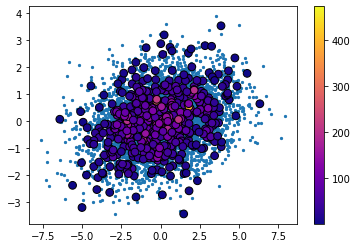

In [ ]:
DIMS = 2
NUM = 50

dg = DataManager(DIMS, generate=True, mean = [0,0], cov = [[5,0.6],[0.6,1]])
X = dg.subsample(n=500)
gp = GP(DIMS)
gp.fit_on_density(X, k=5)
density_mean, density_std = gp.predict(NUM)

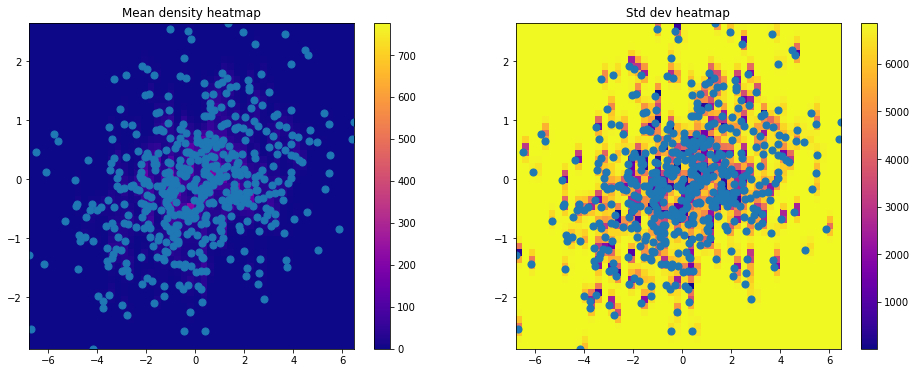

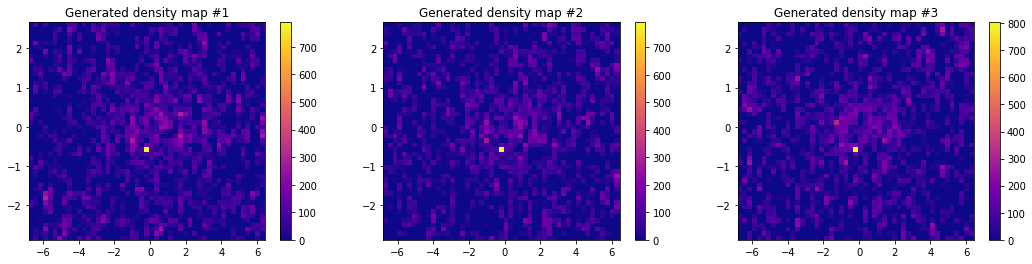

In [ ]:
gp.plot()
density_maps = gp.generate_posteriors(3)

## 3D

In [ ]:
DIMS = 3
NUM = 10

dg = DataManager(DIMS, generate=True)
X = dg.subsample(n=300)
gp = GP(DIMS)
gp.fit_on_density(X, k=5)
density_mean, density_std = gp.predict(NUM)

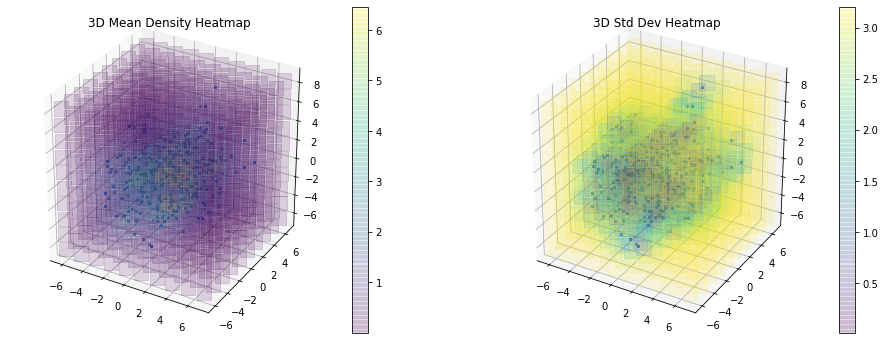

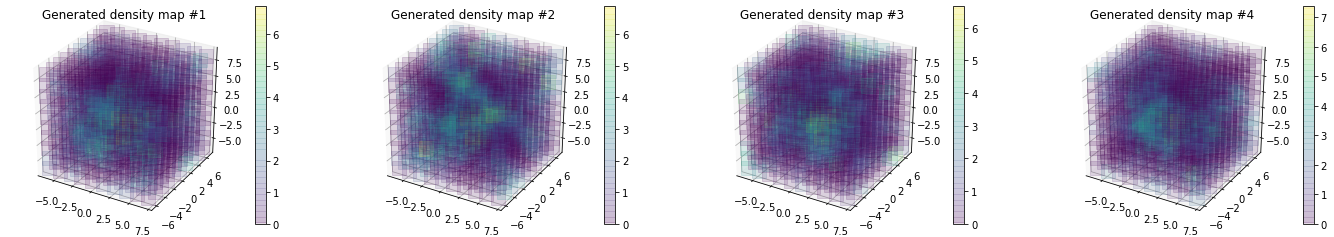

In [ ]:
gp.plot()
gp.generate_posteriors(4)

## Create new clusters by sampling in 2D

The choice of sampling method depends on the specific characteristics of the density map and the desired properties of the generated samples. 

**MCMC sampling** involves constructing a Markov chain whose stationary distribution is the target distribution. It generates samples by running the Markov chain for a sufficient number of steps and collecting samples from the chain. This method can be efficient if the Markov chain mixes well, but may be slow to converge to the stationary distribution. <br> <br>
*Pros:*
- Can be efficient if the Markov chain mixes well
- Can generate correlated samples
- Can sample from complex distributions<br>

*Cons:*
- May be slow to converge to the stationary distribution
- May require careful tuning of the Markov chain<br>

<br>

**Rejection sampling** involves generating samples uniformly at random from the sample space, and accepting them with a probability proportional to their density. This method can be inefficient if the density varies significantly across the sample space.<br>

*Pros:*
- Simple to implement
- Can handle high-dimensional sample spaces

*Cons:*
- Can be inefficient if the density varies significantly across the sample space
- Generates uncorrelated samples


In [ ]:
class Sampler:
    def __init__(self, density_map, num_samples, random_seed):
        """
        Initialize the sampler.

        Parameters
        ----------
        density_map: DensityMap object
            The discrete density map.
        num_samples: int
            The number of samples to generate.
        step_size: float
            The standard deviation of the normal distribution used to generate new points.
        random_seed: int
            The random seed used to initialize the random number generator.
        """
        self.density_map = density_map
        self.num_samples = num_samples
        self.random_seed = random_seed
        self.num_dimensions = density_map.dim 

    def _interpolate(self, point):
        """
        TODO? - i am not sure if it is needed - it depends on the grid step and
        the number of stars in the sample

        Use linear interpolation to estimate the density at a point.

        Parameters
        ----------
        point: array
            An array of shape (D,) containing the point at which to estimate the density.

        Returns
        -------
        density: float
            The estimated density at the point.
        """
        return

    def truncated_normal(self, mean, cov, size):
      """
      Generate samples from a truncated normal distribution.

      Parameters
      ----------
      mean: array
          An array of shape (D,) specifying the mean of the normal distribution.
      cov: float
          The covariance of the normal distribution.
      size: int
          The number of samples to generate.

      Returns
      -------
      samples: array
          An array of shape (size, D) containing the generated samples.
      """
      # initialize the samples array
      samples = np.zeros((size, len(mean)))

      #  specifying the bounds of the truncated normal distribution in each dimension.
      bounds = self.density_map.get_bounds()

      # Generate samples from the truncated normal distribution in each dimension
      for d in range(len(mean)):
          a, b = bounds[d]
          mu, sigma = mean[d], cov
          samples[:, d] = st.truncnorm((a - mu) / sigma, (b - mu) / sigma, mu, sigma).rvs(size=size)

      return samples


class MCMCSampler(Sampler):
    def sample(self, step_size=0.8):
        """
        Generate samples from the density map using MCMC sampling*.
        * this is a modified version in which the previous value is not kept
        when a sample is rejected - the sampler iterates again until the counter
        reaches the number of desired samples.

        Returns
        -------
        samples: array
            An array of shape (num_samples, num_dimensions) containing the generated samples.
        """
        # initialize the samples array and set the initial sample, declare const
        samples = np.zeros((self.num_samples, self.num_dimensions))
        samples[0] = np.zeros(self.num_dimensions)
        density = self.density_map.find_density(samples[0])
        np.random.seed(self.random_seed)


        # run the MCMC sampler
        count = 1
        while count < self.num_samples:
            # sample a new point from a truncated normal distribution centered at the current point
            new_point = self.truncated_normal(mean=samples[count-1], cov=step_size**2, size=1)

            # the density at the new point
            prev_density = density.copy() 
            density = self.density_map.find_density(new_point)
            
            # the acceptance probability
            acceptance_prob = np.min([1.0, density / prev_density])

            # apply Metropolis algorithm to decide if accept the new point
            if np.random.rand() < acceptance_prob:
                samples[count] = new_point
                count +=1

        return samples


class RejectionSampler(Sampler):
  def sample(self):
        """
        Generate samples from the density map using rejection sampling.

        Returns
        -------
        samples: array
            An array of shape (num_samples, num_dimensions) containing the generated samples.
        """

        # initialize, declare the sampler constants 
        samples = np.zeros((self.num_samples, self.num_dimensions))
        np.random.seed(self.random_seed)
        max_density = self.density_map.get_max_density()
        bounds = self.density_map.get_bounds()

        # run the rejection sampler
        count = 0
        while count < self.num_samples:
            # sample a point uniformly at random from the sample space
            sample = []
            for d in range(self.num_dimensions):
                lower, upper = bounds[d]
                sample.append(np.random.uniform(lower, upper))

            # accept the sample with probability proportional to its density
            density = self.density_map.find_density(sample)
            if np.random.rand() < density / max_density:
                samples[count] = sample
                count += 1

        return samples

### MCMC sampling results

<ipython-input-4-712c389899c8>:105: RuntimeWarning: divide by zero encountered in double_scalars
  acceptance_prob = np.min([1.0, density / prev_density])
<ipython-input-4-712c389899c8>:105: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_prob = np.min([1.0, density / prev_density])


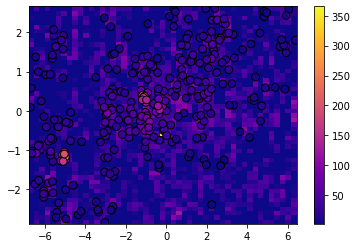

In [ ]:
sampler = MCMCSampler(density_maps[0], 300, random_seed=40)
samples = sampler.sample(step_size=0.8)
Xp = []
for i in range(gp.grid.shape[1]):
    Xp.append(gp.grid[:,i].reshape(gp.reshape_arr))
Z = np.reshape(density_maps[0].density_map, gp.reshape_arr)
x = samples

plt.pcolormesh(Xp[0], Xp[1], Z, cmap="plasma")
plt.scatter(x[:,0], x[:,1], c=estimate_density(x), edgecolor="k",s=60,cmap="plasma")

#plt.scatter(samples[:,0], samples[:,1],s=20)
plt.colorbar()
plt.show()

### Rejection sampling results

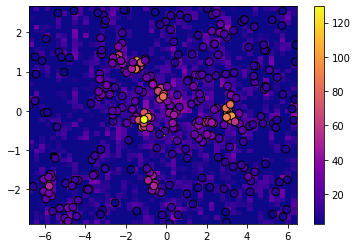

In [ ]:
sampler = RejectionSampler(density_maps[0], 300, random_seed=30)
samples = sampler.sample()
Xp = []
for i in range(gp.grid.shape[1]):
    Xp.append(gp.grid[:,i].reshape(gp.reshape_arr))
Z = np.reshape(density_maps[0].density_map, gp.reshape_arr)
x = samples

plt.pcolormesh(Xp[0], Xp[1], Z, cmap="plasma")
plt.scatter(x[:,0], x[:,1], c=estimate_density(x), edgecolor="k",s=60,cmap="plasma")

#plt.scatter(samples[:,0], samples[:,1],s=20)
plt.colorbar()
plt.show()

In [ ]:
data = np.loadtxt('sink_m1.e5.dat', skiprows=1)

In [ ]:
DIMS = 7
NUM = 50

dg = DataManager(DIMS)
X = dg.subsample(n=100)
gp = GP(DIMS)
gp.fit_on_density(X, k=5)
density_mean, density_std = gp.predict(NUM)

running this needs more memory - colab does not work